In [1]:
import os
try:
    print(file_path)
except:
    file_path = os.path.abspath('')
    os.chdir(os.path.dirname(file_path))
    print(file_path)

/home/mrzaizai2k/code_Bao/livenessDetection/notebook


In [2]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from src.pyimagesearch.livenessnet import LivenessNet

2024-03-18 22:03:43.128858: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-18 22:03:43.130271: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-18 22:03:43.158520: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-18 22:03:43.159359: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 22:03:43.590050: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

# PREPROCESSING DATA

In [3]:
INIT_LR = 1e-3
DECAY_STEPS=500,
DECAY_RATE=0.9,

EPOCHS = 100
batch_size = 8
img_height = 32
img_width = 32
PATIENCE = 10

liveness_model_path="models/liveness"
data_dir = "dataset"


In [4]:

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3635 files belonging to 2 classes.
Using 2908 files for training.
Found 3635 files belonging to 2 classes.
Using 727 files for validation.


2024-03-18 22:03:44.285978: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-18 22:03:44.286177: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['fake', 'real']


Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

* Dataset.cache keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

* Dataset.prefetch overlaps data preprocessing and model execution while training.
Interested readers can learn more about both methods, as well as how to cache data to disk in the Prefetching section of the Better performance with the tf.data API guide.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# TRAINING

In [7]:

print("[INFO] compiling model...")

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    INIT_LR,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
    staircase=True)

opt = Adam(learning_rate=lr_schedule)

model = LivenessNet.build(width=img_width, height=img_height, depth=3, classes=num_classes)
model.summary()

# model.compile(loss="binary_crossentropy", optimizer=opt,
# 	metrics=["accuracy"])


[INFO] compiling model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
 dense_1 (Dense)             (None, 512)               1049088   
                            

In [8]:
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,
  callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)],

)

Epoch 1/100


364/364 [==============================] - 85s 207ms/step - loss: 0.5522 - accuracy: 0.7765 - val_loss: 1.8670 - val_accuracy: 0.3659
Epoch 2/100
364/364 [==============================] - 71s 196ms/step - loss: 0.4636 - accuracy: 0.8054 - val_loss: 0.5386 - val_accuracy: 0.8748
Epoch 3/100
364/364 [==============================] - 69s 191ms/step - loss: 0.3787 - accuracy: 0.8576 - val_loss: 0.5041 - val_accuracy: 0.7552
Epoch 4/100
364/364 [==============================] - 78s 213ms/step - loss: 0.3710 - accuracy: 0.8573 - val_loss: 5.8846 - val_accuracy: 0.6795
Epoch 5/100
364/364 [==============================] - 88s 243ms/step - loss: 0.4081 - accuracy: 0.8473 - val_loss: 0.4563 - val_accuracy: 0.8253
Epoch 6/100
364/364 [==============================] - 84s 231ms/step - loss: 0.5277 - accuracy: 0.7534 - val_loss: 0.6679 - val_accuracy: 0.7345
Epoch 7/100
364/364 [==============================] - 81s 224ms/step - loss: 0.4198 - accuracy: 0.8122 - val_loss: 1.5371 - val_accurac

# TESTING

In [10]:
face_path = "test_images/28.png"

img = tf.keras.utils.load_img(
    face_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
print("predictions", predictions)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 [==============================] - 1s 807ms/step
predictions [[ 3.9607782 -0.63957  ]]
This image most likely belongs to fake with a 99.01 percent confidence.


# Save models

In [11]:

# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open(f'{liveness_model_path}/model.tflite', 'wb') as f:
    f.write(tflite_model)
    print (f"Tflite model saved in")

INFO:tensorflow:Assets written to: /tmp/tmpfnp13hsm/assets


INFO:tensorflow:Assets written to: /tmp/tmpfnp13hsm/assets
2024-03-18 23:31:59.916813: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2024-03-18 23:31:59.916903: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2024-03-18 23:31:59.919277: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfnp13hsm
2024-03-18 23:31:59.940231: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2024-03-18 23:31:59.940264: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpfnp13hsm
2024-03-18 23:32:00.066555: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2024-03-18 23:32:00.090625: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2024-03-18 23:32:00.906343: I tensorflow/cc/saved_model/loader.cc:215] Running initializatio

Tflite model saved in


In [12]:

model.save(f"{liveness_model_path}/saved_model.h5")
print("\nsaved model h5")

/home/mrzaizai2k/code_Bao/livenessDetection/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



saved model h5


# Plot Training

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(0, len(history.history['accuracy']))

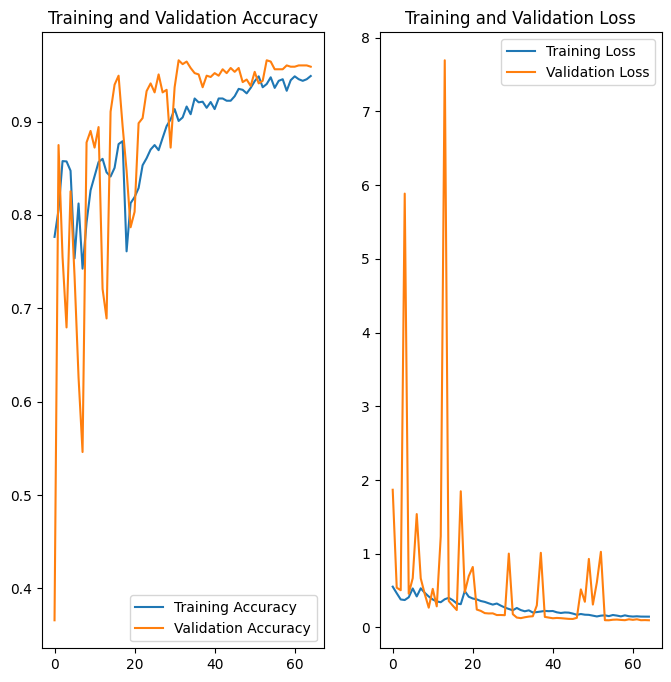

In [14]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
 

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('docs/train.jpg')
plt.show()

# Test TFLite

In [15]:
face_path = "test_images/28.png"

img = tf.keras.utils.load_img(
    face_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch


In [16]:
TF_MODEL_FILE_PATH = 'models/liveness/model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)
print(interpreter.get_signature_list())

classify_lite = interpreter.get_signature_runner('serving_default')
print("classify_lite", classify_lite)

predictions_lite = classify_lite(sequential_input=img_array)['fc2']
score_lite = tf.nn.softmax(predictions_lite)
print("score_lite", score_lite)

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)


{'serving_default': {'inputs': ['sequential_input'], 'outputs': ['fc2']}}
classify_lite <tensorflow.lite.python.interpreter.SignatureRunner object at 0x7f13463d84f0>
score_lite tf.Tensor([[0.99005157 0.00994839]], shape=(1, 2), dtype=float32)
This image most likely belongs to fake with a 99.01 percent confidence.


: 